In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from ParticleFilter import sample_normal_model, single_step_particle_filter, normal_model_pdf


In [7]:

## setup params
NUM_OF_BEACONS = 4
NUM_OF_AGENTS = 1
STATE_SIZE_2D = 2
SINGLE_RANGE_MEASUREMENT_SIZE = 1
RANGE_MEASUREMENT_SIZE = NUM_OF_BEACONS * SINGLE_RANGE_MEASUREMENT_SIZE * NUM_OF_AGENTS
# AGENTS_INDEX = [i for i in range(STATE_SIZE_2D*NUM_OF_AGENTS)]
# BEACONS_INDEX = [AGENTS_INDEX[-1] + 1 +  i for i in range(STATE_SIZE_2D*NUM_OF_BEACONS)]
TOTAL_STATE_SIZE = NUM_OF_AGENTS * STATE_SIZE_2D + NUM_OF_BEACONS * STATE_SIZE_2D
sigma_transition_agent = 0.5
sigma_transition_beacon = 0.5
sigma_measurement = 0.1
stepsize = 2
n_steps = 50
n_particles = 100
# model definition
cov_measurement = np.diag([sigma_measurement**2 for i in range(RANGE_MEASUREMENT_SIZE)])
cov_transition_agent = [sigma_transition_agent**2 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_beacon = [sigma_transition_beacon**2 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
cov_transition = np.diag(cov_transition_agent + cov_transition_beacon)
propagate_state = lambda x, u: x + sample_normal_model(u, cov_transition)
get_agent_index = lambda i: slice(i*STATE_SIZE_2D, i*STATE_SIZE_2D + STATE_SIZE_2D)
get_beacon_index = lambda i: slice(STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D, STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D + STATE_SIZE_2D)
get_agent_position = lambda x, i: x[get_agent_index(i)]
get_beacon_postion = lambda x, j: x[get_beacon_index(j)]
def calculate_true_range_meas(x):
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):
        current_agent_position = x[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            current_beacon_position = x[get_beacon_index(j)]
            z[i*NUM_OF_BEACONS + j] = np.linalg.norm(current_agent_position - current_beacon_position)
    return z

def measurements_model(x, cov = cov_measurement):
    return calculate_true_range_meas(x) + sample_normal_model(np.zeros(RANGE_MEASUREMENT_SIZE), cov)

measurements_likelihood = lambda z, x: normal_model_pdf(z, calculate_true_range_meas(x), cov_measurement)


In [8]:
## test models  
if 1:
    x = np.array([0, 0, 1, 0, 2, 0, 3, 0, 4, 0])*100
    u = np.zeros(TOTAL_STATE_SIZE)
    print(measurements_model(x))
    print(propagate_state(x, u))

[100.0778458  200.00874295 299.96178234 400.1263007 ]
[9.36208400e-01 3.69790231e-01 9.87985905e+01 6.77824166e-01
 1.99084032e+02 1.36107756e-01 2.99761935e+02 3.23125659e-01
 3.99790361e+02 4.66317950e-01]


In [10]:
def state_to_agent_and_beacons_pos(x):
    agents_pos = np.zeros((NUM_OF_AGENTS, STATE_SIZE_2D))
    beacons_pos = np.zeros((NUM_OF_BEACONS, STATE_SIZE_2D))
    for i in range(NUM_OF_AGENTS):
        agents_pos[i] = get_agent_position(x, i)
    for j in range(NUM_OF_BEACONS):
        beacons_pos[j] = get_beacon_postion(x, j)
    return agents_pos, beacons_pos
def agent_and_beacons_pos_to_state(agents_pos, beacons_pos):
    x = np.zeros(TOTAL_STATE_SIZE)
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] = agents_pos[i]
    for j in range(NUM_OF_BEACONS):
        x[get_beacon_index(j)] = beacons_pos[j]
    return x

In [11]:
## test conversion functions
if 1:
    x = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])
    agents_pos, beacons_pos = state_to_agent_and_beacons_pos(x)
    print(agents_pos, beacons_pos)
    print(agent_and_beacons_pos_to_state(agents_pos, beacons_pos))

[[0. 0.]] [[1. 1.]
 [2. 2.]
 [3. 3.]
 [4. 4.]]
[0. 0. 1. 1. 2. 2. 3. 3. 4. 4.]


In [12]:
## generate ground truth
agent_position_0 = np.array([0,0])
becons_1_position_0 = np.array([10,10])
becons_2_position_0 = np.array([-10,10])
becons_3_position_0 = np.array([10,-10])
becons_4_position_0 = np.array([-10,-10])
x_0 = agent_and_beacons_pos_to_state([agent_position_0], [becons_1_position_0, becons_2_position_0, becons_3_position_0, becons_4_position_0])

#genrate u  commend vector
u = (np.random.rand(TOTAL_STATE_SIZE, n_steps) - 0.5) * stepsize

## create ground truth
x = np.zeros((TOTAL_STATE_SIZE, n_steps))
x[:,0] = x_0
z = np.zeros((RANGE_MEASUREMENT_SIZE, n_steps))
z[:,0] = measurements_model(x[:,0])
for i in range(1, n_steps):
    x[:,i] = propagate_state(x[:,i-1], u[:,i])
    z[:,i] = measurements_model(x[:,i])

## plot ground truth
if 0:
    fig, ax = plt.subplots()
    ax.plot(x[0,:], x[1,:], 'r')
    ax.plot(x[2,:], x[3,:], 'g')
    ax.plot(x[4,:], x[5,:], 'b')
    ax.plot(x[6,:], x[7,:], 'y')
    ax.plot(x[8,:], x[9,:], 'm')
    plt.show()


[-7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7.88117309
 -7.88117309 -7.88117309 -7.88117309 -7.88117309 -7

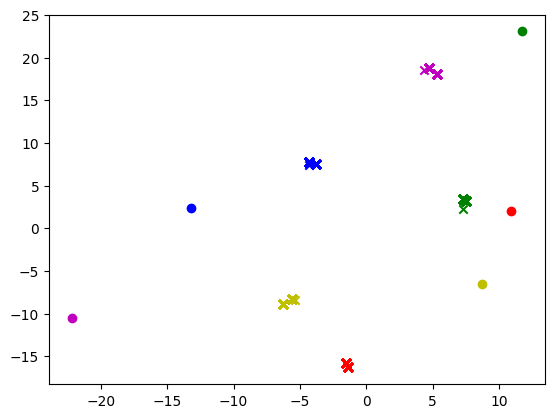

In [13]:
## particle filter
n_particles = 1000
particles = (np.random.rand(n_particles, TOTAL_STATE_SIZE) - 0.5) * 15
for i in range(n_steps):
    particles = single_step_particle_filter(particles, u[:,i], z[:,i], propagate_state, measurements_likelihood)
    print(particles[:,1])
    
## plot final particles
if 1:
    fig, ax = plt.subplots()
    ax.scatter(x[0,49], x[1,49], c = 'r')
    ax.scatter(x[2,49], x[3,49], c = 'g')
    ax.scatter(x[4,49], x[5,49], c = 'b')
    ax.scatter(x[6,49], x[7,49], c = 'y')
    ax.scatter(x[8,49], x[9,49], c = 'm')
    ax.scatter(particles[:,0], particles[:,1], c = 'r', marker = 'x')
    ax.scatter(particles[:,2], particles[:,3], c = 'g',  marker = 'x')
    ax.scatter(particles[:,4], particles[:,5], c = 'b',  marker = 'x')
    ax.scatter(particles[:,6], particles[:,7], c = 'y',  marker = 'x')
    ax.scatter(particles[:,8], particles[:,9], c = 'm',  marker = 'x')
    plt.show()

In [8]:
z[:,0]

array([14.20925481, 14.22785826, 14.32072574, 14.02638148])